# Using Python and Monte Carlo to Simulate Student Finance Amortization

## TL;DR - Quick Abstract
I became frustrated with the numbers not adding up on my Student Loan statements and speculative opinions about never paying it off and getting the loan cancelled. I wanted to gauge my likelihood of paying off the full loan and simulated my earnings using Monte Carlo and another method. I used Python to implement it - code walk through below.

## Intro

In the last year, I have developed a keen interest in personal finance and utilising automation to improve the handling and growth of personal finances (brought on by Ramit Sethi's amazing [book](https://www.amazon.co.uk/Will-Teach-You-Rich-Second/dp/1523505745/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=&sr=) and [blog](https://www.iwillteachyoutoberich.com/), which I highly recommend). Consequently, I became interested in my Student Loan and my lifetime repayment (amortization) of it. 

In the UK, students can take out university loans for both tuition fees and living costs ("maintenance loans") with [Student Finance England](https://www.gov.uk/student-finance), who provide loans underwritten by the Student Loans Company who act on behalf of the government. Once you leave university and enter employment you then begin to pay off your loan on a monthly schedule, as part of your tax deductions. Crucially, if you do not pay off your loan, plus interest, in 30 years, your loan is cancelled.

## Rationale

There are several reasons I became so interested in and, frankly, frustratingly intrigued by this project:
* The **main reason**: the more reading I did into the loans, the more I realised how murky and dense a lot of the documentation is surrounding repayment - even analysing my statements from the Student Loans Company for the interest accrued in a given period didn't make sense when I ran the numbers - it's confusing, and no-one online or in my circle could give me clear answers
* Conflicting opinions surrounding paying off the loan - everything from "it comes out of my tax so I don't even notice it", to "most students won't pay it off and it will get cancelled, so paying upfront might be wasting your money" - but "most students" a huge variance in earnings (and therefore amortization) between subjects, universtiy attended and industry
* Graduates today in the UK, leave university with a staggering sum of debt - I wanted to cut through the noise and understand exactly how the loans work as part of my research and **quantify my probability of paying it off**

Now, working in Data Science, and trained at university as a scientist, nothing annoys me more than the concept of not needing to understand something, or learning something superficially. I left university with a total of £42,000 in debt, and so the notion of blindly paying a huge debt and not knowing how it works really frustrated me. 

## Questions
Here are the questions I wanted to answer:
1. How likely am I, and other graduates, to pay off our student loans inside of the 30 year payment window, following university courses?
2. If you manage to save money, or come across a sum of money (e.g. inheritance), should you put it towards your loan in the form of voluntary payments?

## Facts
* Students taking out loans since 2012 are on "Plan 2" loans
* You only start paying these back when you earn more than £2,214 a month or £26,568 a year (pre-tax)
* You are due to start repaying the April after graduating (or the April 4 years after starting - whichever comes first) - i.e. if you enter employment immediately after graduating, you won't start repying on your payslips until the following April
* You begin acruing interest from the day of your first loan (i.e. shortly after arriving at university)
* Interest acrues daily
* [Plan 2 loans are written off](https://www.gov.uk/repaying-your-student-loan/when-your-student-loan-gets-written-off-or-cancelled) 30 years after the April you were first due to repay

## Student Loans are not like other loans, they're more of a tax
* Regular loans from the bank are drawn up with a fixed interest rate and regular payments (e.g. monthly) which are independent of your salary
* The amount you pay back to your Student Loan is determined by how much you earn, so it behaves much more like a tax
* In this way, people who earn more contribute more, paying for the loans of graduates who earn less
* Interest rates are variable, not fixed - they are calculated as RPI inflation plus 3%, so rates have been as high as 6.6% since 2012

## Method
* Build a simulator in Python which runs through 30 years of payments towards the loan, with the loan simultanously accruing interest daily
* Simulate across many different salary trajectories, using Monte Carlo (more below)

# Import Python Libraries

In [5]:
import os
import pandas as pd
import numpy as np

# Working with datetime objects
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd

# Scraping interest rates off the web
import requests
from bs4 import BeautifulSoup

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Build Functions
Read in my student finance statements for all loan instalments throughout my degree (paid from the Student Finance England)

In [6]:
def readPayments(file_name, date_header="PaymentDate"):
    '''
    Reads in student finance statement as a pandas dataframe.
    Function accepts csv file containing dates and amounts of
    payments made from Student Finance as part of the loan.
    '''
    
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc, index_col=date_header, parse_dates=True)
    
    return paymentsData

# Read in my statement detailing university instalments
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)
myPayments.drop("Instalment", axis = 1, inplace = True)
myPayments.head()

,Gross
PaymentDate,
2014-09-25,1191.3
2014-10-15,2250.0
2015-01-05,1191.3
2015-02-04,2250.0
2015-04-20,1227.4


A basic functions for calculating monthly [student finance payments](https://www.gov.uk/repaying-your-student-loan/what-you-pay) based on your gross salary (pre-tax). You can find similar functions for tax (based on UK [tax bands](https://www.gov.uk/income-tax-rates)), [national insurance contribution (NIC)](https://www.gov.uk/national-insurance/how-much-you-pay) at the bottom of this page.

In [7]:
def calc_student_finance_PM(grossSalaryPA):
    '''
    Calculates student finance payments per month deducted
    from gross salary based on thresholds published by
    Student Finance England.
    '''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM

To calculate how much I owed at the end of university, I need to calculate the interest that is applied to a given instalment, which changes at the start each academic year (September 1st). The first part was to get these rates from the [government website](https://www.gov.uk/guidance/how-interest-is-calculated-plan-2), using a simple web scraper (```BeautifulSoup```) which takes the interest rates for different academic years from the government website and stores them in a dictionary. The second part was to build a function which could take any date during my degree and find the interest rate for payments made at that point in time.

In [8]:
## Web scrape historic interest rates

url = 'https://www.gov.uk/guidance/how-interest-is-calculated-plan-2'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')
table_rows = results.find_all('tr')

# Store interest rates in dictionary of academic years
historicInterest = {}
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) > 0:
        row[0] = row[0].split('to')
        row[0][0] = pd.Timestamp(row[0][0])
        row[0][1] = pd.Timestamp(row[0][1])
        year = str(row[0][0].year)
        historicInterest.setdefault(year, 0)
        historicInterest[year] = {}
        historicInterest[year].setdefault("start", 0)
        historicInterest[year]["start"] = row[0][0].date()
        historicInterest[year].setdefault("end", 0)
        historicInterest[year]["end"] = row[0][1].date()
        historicInterest[year].setdefault("rate", 0)
        historicInterest[year]["rate"] = float(row[1][:-1])/100

def find_interest_rate(paymentDate):
    '''Finds interest rate of applied to loan for a given date'''
    try:
        year = paymentDate.year
        sdate = historicInterest[str(year)]["start"]
        edate = historicInterest[str(year)]["end"]
        delta = edate - sdate
    
        allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)] # create list of all dates in date range sdate to edate
        
        # Dates in the second semester are in the next calendar year but same academic year
        # in this case, take the rate of the previous calendar year
        if paymentDate in allDates:
            rate = historicInterest[str(year)]["rate"]
        else:
            rate = historicInterest[str(year-1)]["rate"]
    except KeyError: # error for dates in next calendar year after the end of the dictionary dates
        rate = historicInterest[str(year-1)]["rate"]
    return rate

To calculate how much I owed after university I need to simulate each passing day's interest (whilst studying) and also add in the instalments arriving from Student Finance England. The function is written such that you can either simulate up to the end of graduation year (August 31st), or up to the start of employment (when you begin paying back the loan), using the ```simEnd``` argument. NB: in my case I was not employed until after the April following graduation, so did not need to build in the rule for this.

In [9]:
def graduate_amount(simEnd, employmentStart, myPayments=None): # simEnd argument ends simulation either on the last payment in data, at the end of graduation academic year or at commencement of employment
    '''
    calculate total student debt owed at employment, 
    end of graduation year or at final instalment manually (using simEnd)
    Alternatively can take manually input total
    '''
    
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = myPayments.index.min()
        if simEnd == "yearEnd":
            graduationYear = myPayments.index.max().year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = myPayments.index.max() # simulation ends at final payment

        delta = timedelta(days=1)
        
        ## Simulate through dates in date period, 
        ## compounding interest each day and adding installments
        
        while startDate <= endDate: # simulate interest compounding up to and including last day
            interestRate = find_interest_rate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in myPayments.index: # check if there was a loan instalment on this day
                cumulativeTotal += myPayments.loc[startDate]["Gross"]
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

In [10]:
def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = find_interest_rate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

### The Main Function!
Using the above functions, the value owed in Student Finance at the start of employment can be calculated. From this point onwards, you begin paying back towards your loan in the style of a tax. In this simulation, interest accrues on the loan daily, and on the last working day of the month (```BMonthEnd()```), your repayment comes out of your salary (details in intro), as in reality. 

In [11]:
def simulate_lifetime_earnings(grossSalaryPA, N, principal, employment_start, method="monte carlo", increases=None):
    '''
    Simulates payment of student debt across career based 
    on monthly tax payments according to estimated salary 
    and simultaneous compounding interest of loan
    '''
    
    salary = [] # store salary trajectory for plotting
    payments_towards = 0 # cumulative total of payments made towards loan across career
    salary.append(grossSalaryPA)
    
    ## Simulation start and end points
    today = pd.Timestamp(employment_start)
    start = today
    edate = today + timedelta(days=N*365) # N years of payments
    delta = timedelta(days=1)
    offset = BMonthEnd() # date each month that tax is paid
    
    cumulativeTotal = principal
    cumulativeList = [] # store the value of the loan at each timestep
    cumulativeList.append(cumulativeTotal)
    
    ## Simulate through N years of payments
    ## interest compounds each day
    ## payment made on last working day of the month
    while today <= edate:
        if method == "monte carlo" and increases is not None:
            if ((today - start).days/365)%5 == 0 and (today - start).days > 0:
                grossSalaryPA *= increases[(today - start).days/365/5]
                
        elif method == "monte carlo" and increases is None:
            print("Please supply monte carlo simulated salary increases")
            
        if method == "median":
            if (today - start).days%365 == 0 and (today - start).days/365 in male_HE.index:
                grossSalaryPA = male_HE.loc[(today - start).days/365]['Earning']

        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if today == offset.rollforward(today) and today.month == offset.rollforward(today).month: # if today in sim is last working day
            cumulativeTotal -= calc_student_finance_PM(grossSalaryPA) # payment made to student finance based on gross salary
            payments_towards += calc_student_finance_PM(grossSalaryPA) # this payment is added to cumulative sum
            cumulativeList.append(cumulativeTotal)
            salary.append(grossSalaryPA)
            
        today += delta

    return cumulativeList, salary, payments_towards

## Simulating Median Graduate Earnings
To try out the simulator, I began by using higher education salary data from an incredibly thorough new report [*The impact of undergraduate degree on lifetime earnings*](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/869263/The_impact_of_undergraduate_degrees_on_lifetime_earnings_research_report_ifs_dfe.pdf). For my personal situation I ran the simulation for median male graduate earnings. The code used here is mostly plotting, which I will skip for space.

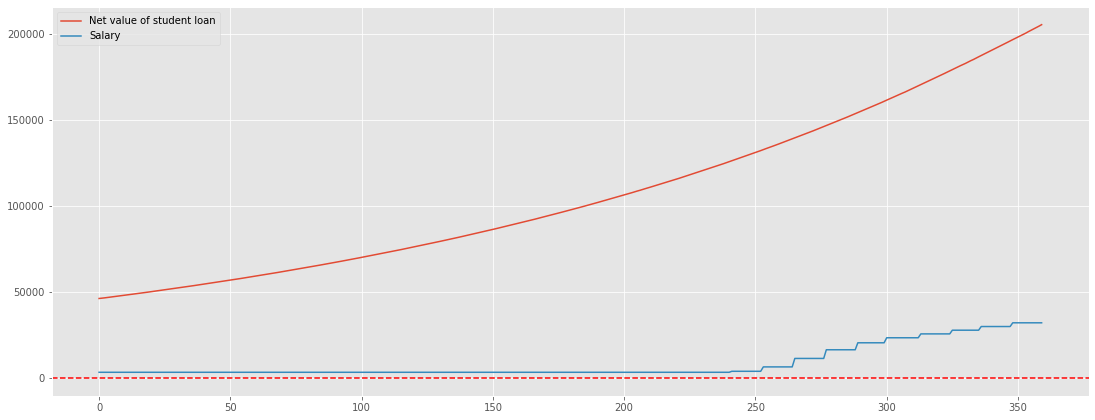

In [12]:
male_HE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_men_HE.csv"),header=None, names = ['Age', 'Earning'])
male_HE['Age'] = male_HE['Age'].round()
male_HE = male_HE.groupby(by='Age').mean()

fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
plt.axhline(y = 0, color = 'r', linestyle = '--')
sim, sal, payments = simulate_lifetime_earnings(grossSalaryPA = male_HE['Earning'].min(),
                                    N = 30,
                                    principal = graduate_amount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                    employment_start = "2019-10-07", 
                                    method = "median")

ax.plot(sim, label = "Net value of student loan")
ax.plot(sal, label = "Salary")
plt.legend(loc="best");
fig.savefig(os.path.join('..','results','median_male_student_loan.png'), dpi=400)

As you can see in the plot above, the median male graduate's salary does not increase fast enough in the early years/over the 30 years to ever overcome the rate of compounding of the loan interest. Thus, the loan's net value spirals upwards, and they never pay it off. At 30 years, the loan will be cancelled. However, there are many confounding variables here - e.g. this is averaged across subjects and university (e.g. [Russell Group](https://russellgroup.ac.uk/about/) and nonRG), which both have very large variance in later life earnings. So this should be looked at purely as an example of the simulation.

# Enter Monte Carlo
Monte Carlo methods are a class of algorithms that rely on repeated random sampling to obtain numerical results - by the law of large numbers, the expected value of a random variable can be approximated by taking the sample mean of independent samples. 

In plain English: "while we don't know what the correct answer or strategy is, we can simulate thousands or millions of attempts and the average will approximate the right answer". Here is a [great example of Monte Carlo simulations](https://towardsdatascience.com/the-house-always-wins-monte-carlo-simulation-eb82787da2a3) showing how the House always wins and it has many other applications in anything that has a probabilistic element or has "risk", e.g. stock market and portfolio performance in Finance etc. 

## My model - Assumptions & Considerations
Since the amount of student finance I will pay across my working life is based on what I earn at time t, and I don't know what I will earn, I can simulate my career earnings using Monte Carlo. In my simulation:
* I have a starting salary for my first job
* I divide the 30 year payment period of the loan into different salary bands for my career
    * I chose 6 separate bands, each 5 years long (but this can be varied with ```salary_levels```)
    * Each salary band represents a salary increase - the increase is taken from a gaussian distribution centred around a mean which is a percentage of my gross salary
    * This percentage around which the distribution is centred decreases the further the simulation runs into my career
* I simulate my career according to these salary bands 1000000 times
* I calculate what the average loan value is after the 30 year payment period

#### Translation: 
As a graduate earner, most salary growth occurs in the early years before levelling off. This means, on average, your percentage salary increase (either as an aggregation of several payrises, or one big jump due to moving job or a promotion) is larger earlier on and gets smaller later in life (as a percentage, not in absolute terms). In my simulation, this is represented by gaussian salary distributions which have a smaller "salary percentage increase" as their mean as it progresses through the salary bands. <br/><br/> However, a payrise of e.g. 30% in x years is not certain - you could have a series of smaller or larger payrises (the aggregate of which are represented in the 5-year jump), or one big jump after 5 years, which is greater or less than 30%. This is the great utility of Monte Carlo - I take my salary as a random variable from a normal distribution, meaning it could be less or more than the average. <br/><br/> For each of these x-year salary bands I can take k samples, resulting in k different salary trajectories for 30 years. I simulate all these trajectories and the monthly payments against my loan and work out in how many of the simulations I pay off my entire loan**

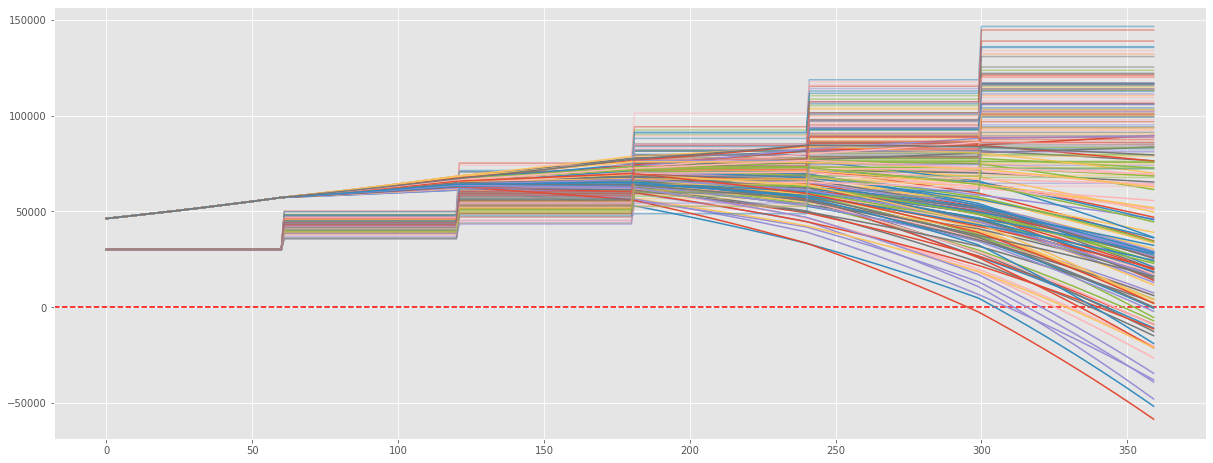

In [13]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
salary_levels = 6
np.random.seed(101)
startingSal = 30000
sims = 100
monte_carlo_increases = pd.DataFrame(np.row_stack([np.random.normal(loc=x, scale=0.1,size=(1,sims)) for x in np.linspace(.1,.4,salary_levels)[::-1]]))
end_values = []
total_payments = []
monte_carlo_increases += 1
monte_carlo_increases.index += 1
totalLoan_values = 0
for column in range(sims):
#     print(monte_carlo_increases[column])
    sim, sal, net_payments = simulate_lifetime_earnings(grossSalaryPA = startingSal,
                                    N = 30,
                                    principal = graduate_amount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                    employment_start = "2019-10-07", 
                                    method = "monte carlo",
                                    increases = monte_carlo_increases[column])
    end_values.append(sim[-1])
    total_payments.append(net_payments)
    ax.plot(sal, label = "Salary", alpha = 0.5)
    ax.plot(sim, label = "Net value of Student Loan")
    
# plt.legend(loc="best");

In [14]:
np.mean(total_payments)

107160.4046229287

## Results
After the 30 year payment period:
* the average loan value is: 
* only in x% of salary trajectories was the loan completely paid off (i.e. crossed the red zero line)
* the average total amount of money paid towards the loan was x

## Evaluation - What should you do?!
#### DISCLAIMER: I am not a financial advisor - any ideas here are purely hypothetical based off simulations with a suite of assumptions & caveats. These are simply my thoughts on potentially effective strategies. If you are unsure about your own personal financial situation, seek the advice of a professional financial advisor.
So what is the conclusion here? What strategy should you take with regard to paying off your student loan?

Firstly, it should be highlighted that debt repayment is a blend of pure arithmetic and also psychology, because as complex creatures, our emotional welfare with regard to debt is affected by multiple factors, e.g. the number of active debt repayments we have, as well as the value of each one. There are different debt consolidation strategies if you have multiple debt repayments to make e.g. [Snowball or Avalanche methods](https://www.thebalance.com/debt-snowball-vs-debt-stacking-453633).

### Loan in Isolation
Secondly, one can start the evaluation by considering the loan in isolation. In the purely practical sense and in isolation, **yes**, one should try and pay it off with extra money, because as seen from the **Results**, on average, one will pay for the loan nearly three times over across your working life time (107160/42000 = 2.55), however, this has **several caveats** to it and it is worth considering the numbers at this point. 

Crucially, the major factor affecting amortisation in this problem is the dynamics between the interest and the repayments. Whilst the loan has an interest rate, the repayments are not fixed, and are instead a percentage of what you earn (more like a tax). This means that if the monthly repayments are not larger than or equal to the monthly interest accrued on the loan, then your debt will grow and grow - this is basic mathematics. However, the key factor is the rate at which your salary increases, because of the powers of compound growth. In order to pay off the loan without much extra debt, your repayments need to chip off the interest plus more, to start notching away at the principal amount. If you were to repay exactly the interest each month, the principal value of the loan would remain constant. To quickly pay off the loan (assuming only salary deductions), and reduce extra money paid through interest, your salary in your first one or two years as a graduate must afford you the ability to pay off more than the interest each month. However, if your salary puts you over the repayment threshold, but not by more than the loan's monthly interest, then the loan will continue to grow. It is the early years' salaries that matter more, because you are attempting to suppress the compound growth of the loan. Even if your salary rises to a substantial amount later in life, if your early salary was "too low", then the loan will have grown to an amount which demands a disproportionately higher salary to overcome the monthly interest later on (because the monthly interest will be much larger given that the loan has been allowed to grow) - this highlights the non-linearity of compound growth. Either your first job as a graduate must pay a salary for which the monthly repayments are greater than the interest rate, OR your salary in your first few years as a graduate must grow fast enough such that repayments outrun the interest. The last option is that if your salary is "too low", you make voluntary repayments to make up the difference.

In a strategetic sense, it would be optimal (for the LOAN ONLY) to remain at a salary below the repayment threshold for your entire career, thereby receiving the degree for free, as you never pay a penny for it. However, this is only when considering the loan in isolation.

### Reality - Time Value of Money
Of course, your loan repayment is not in isolation of other factors, as this is reality. The strategy of keeping a low salary is somewhat counter intuitive, as you attend university to gain a higher earning potential and tap into investments across different asset classes more easily, so purposely remaining on a low salary seems wrong.

**Should you allocate extra money towards the loan?** <br/> It's multi-dimensional! It comes down to what else you are or can invest any extra money in for the long term, because of the **[time-value of money](https://en.wikipedia.org/wiki/Time_value_of_money)**, which is the concept that the same sum of money is worth more now than later on in life because of it's earning potential and because of inflation. If you come across a substantial amount of money (either from a savings account, inheritance etc), you could invest it and grow it, utilising compound interest. e.g. using a sit-and-hold strategy in an account with a higher compound interest rate than the student loan, e.g. investing in public equities, due to compounding, this spare money could grow. Even if you spend your working life trying to make extra contributions to the student loan, you could have invested the same money into something with higher growth than the student loan itself, allowing you to offset the lifetime amount contributed to the loan (just on tax) and still have profit. The same concept applies to purchasing a house and leveraging its appreciation in value, or renting it as a passive source of income. 

There are also externalities to the time value of money other than monetary return, in the form of opportunity cost. For example, extra money right now can buy opportunity, i.e. investment in yourself, such as courses, seminars and conferences, which grows your network and generates more opportunity, and eventually greater profit. 

The crucial factor here is **time**. To avoid paying staggering interest, paying off the loan in one large payment is optimal, but if that repayment takes too long, you've wasted time that the same money could have been growing inside an investment. To complicate matters, if you had the sum of money required to make that kind of one-off payment, you could also argue that you should invest that (e.g. in the stock market) immediately and then contribute additional monthly income across your career, which could compound to a size which dwarfs the student loan interest. In most cases, graduates are unlikely to have that kind of lump sum, and to attempt to save that money to then pay towards the student loan, as it is simultaneously compounding will leave you forever chasing your own tail.

## Conclusion
Unfortunately, I didn't reach the crystal clear conclusion I hoped I would - if the average loan value after 30 years was much lower (closer to the principal), it would have been clearer to let the loan expire and not voluntarily contribute. However, if you encounter a sum of money equating your student loan, you could argue either way that you should pay it off, or invest it into an asset with higher growth. The more convincing argument is that of **opportunity cost** - as a young graduate, the time/effort/money invested in your first few years can affect the course of your career - access to opportunity which you can invest extra money in now, rather than waiting to pay off the loan and then addressing this.

Finally, apart from the greater understanding of the student loans system that I have gained, this exercise did highlight something important. We **do not have enough data** publicly available and consumable about graduate lifetime earnings. The [report]() mentioned above has done a great job of working with what is available, but is mathematically dense in parts and not generally in laymans terms. University courses in the UK now cost £9,250 per year, leaving graduates with staggering amounts of debt, and having gone through the applications process myself, a shared experience with school peers, not once did I encounter information regarding return on course costs in the form of graduate earnings for my subject or industry.

This project has shown me that the notion of "don't pay the loan off in full as it gets cancelled later on" is misguided in its lack of additional advice. It depends on subject. It depends on university. It depends on salary. It depends if you invest the money in something else. With this information, prospective future students would get sufficient return on their course for the costs involved.

